# Experiment 4 with regulatization
This experiment adds data augmentation to the experiment 3 model. It also adds an l1 regularization term

In [1]:
# model training using tensorflow
import numpy as np
import os
import cv2
from matplotlib import pyplot

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
'''
Configuration Code
'''
def get_n_cores():
    """The NSLOTS variable, If NSLOTS is not defined throw an exception."""
    nslots = os.getenv("NSLOTS")
    if nslots is not None:
        return int(nslots)
    raise ValueError("Environment variable NSLOTS is not defined.")


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

NUM_GPUS = len(tf.config.experimental.list_physical_devices("GPU"))
print("Num GPUs Available: ", NUM_GPUS)
if NUM_GPUS > 0:
    print(os.getenv("CUDA_VISIBLE_DEVICES"))

tf.config.set_soft_device_placement(True)
tf.keras.backend.set_floatx("float32")
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(get_n_cores())

Num GPUs Available:  1
0


In [3]:
batch_size = 32

DATA_DIRECTORY = os.path.join(os.getcwd(), 'train_data')

size = (224,224) # height, width

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIRECTORY,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=size,
  batch_size=batch_size
)

Found 2700 files belonging to 2 classes.
Using 2160 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIRECTORY,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=size,
  batch_size=batch_size
)

Found 2700 files belonging to 2 classes.
Using 540 files for validation.


In [5]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3))

In [6]:
'''
Data augmentation layer
'''
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

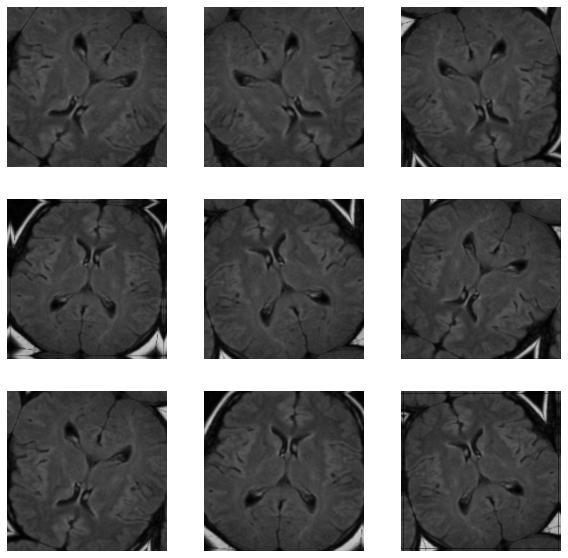

In [7]:
'''
Plot some of the augmented images
 - this shows how the images could be augmented, with flips and rotations
'''
pyplot.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = pyplot.subplot(3, 3, i + 1)
        pyplot.imshow(augmented_images[0].numpy().astype("uint8"))
        pyplot.axis("off")

In [9]:
num_classes = 2

model = Sequential([
    data_augmentation,
    normalization_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, kernel_regularizer='l1')
])

In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
 )

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)       

In [ ]:
epochs=200

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/200
68/68 [==============================] - 5s 81ms/step - loss: 1.0049 - accuracy: 0.5444 - val_loss: 0.8544 - val_accuracy: 0.5296
Epoch 2/200
68/68 [==============================] - 5s 71ms/step - loss: 0.7971 - accuracy: 0.6259 - val_loss: 0.7439 - val_accuracy: 0.6685
Epoch 3/200
68/68 [==============================] - 5s 72ms/step - loss: 0.6790 - accuracy: 0.7144 - val_loss: 0.6859 - val_accuracy: 0.7296
Epoch 4/200
68/68 [==============================] - 5s 73ms/step - loss: 0.5946 - accuracy: 0.7519 - val_loss: 0.5449 - val_accuracy: 0.8019
Epoch 5/200
68/68 [==============================] - 5s 73ms/step - loss: 0.5303 - accuracy: 0.7968 - val_loss: 0.4830 - val_accuracy: 0.8333
Epoch 6/200
68/68 [==============================] - 5s 68ms/step - loss: 0.4609 - accuracy: 0.8333 - val_loss: 0.4546 - val_accuracy: 0.8556
Epoch 7/200
68/68 [==============================] - 5s 67ms/step - loss: 0.4386 - accuracy: 0.8417 - val_loss: 0.5084 - val_accuracy: 0.8148
Epoch 

68/68 [==============================] - 4s 62ms/step - loss: 0.1053 - accuracy: 0.9681 - val_loss: 0.1510 - val_accuracy: 0.9556
Epoch 59/200
68/68 [==============================] - 5s 68ms/step - loss: 0.1138 - accuracy: 0.9685 - val_loss: 0.1552 - val_accuracy: 0.9593
Epoch 60/200
68/68 [==============================] - 5s 67ms/step - loss: 0.0917 - accuracy: 0.9741 - val_loss: 0.1861 - val_accuracy: 0.9537
Epoch 61/200
68/68 [==============================] - 5s 68ms/step - loss: 0.0867 - accuracy: 0.9764 - val_loss: 0.1740 - val_accuracy: 0.9537
Epoch 62/200
68/68 [==============================] - 5s 68ms/step - loss: 0.0931 - accuracy: 0.9741 - val_loss: 0.1863 - val_accuracy: 0.9463
Epoch 63/200
68/68 [==============================] - 5s 76ms/step - loss: 0.0880 - accuracy: 0.9755 - val_loss: 0.1351 - val_accuracy: 0.9630
Epoch 64/200
68/68 [==============================] - 5s 69ms/step - loss: 0.1105 - accuracy: 0.9667 - val_loss: 0.1415 - val_accuracy: 0.9556
Epoch 65/200

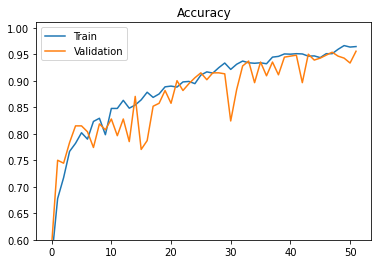

In [14]:
'''
Plot the accuracy
'''
pyplot.title("Accuracy")
pyplot.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label = "Train")
pyplot.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label = "Validation")
pyplot.ylim((0.6,1.01))
pyplot.legend()
pyplot.show()

In [15]:
model.save('models/experiment_004')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/experiment_004/assets
